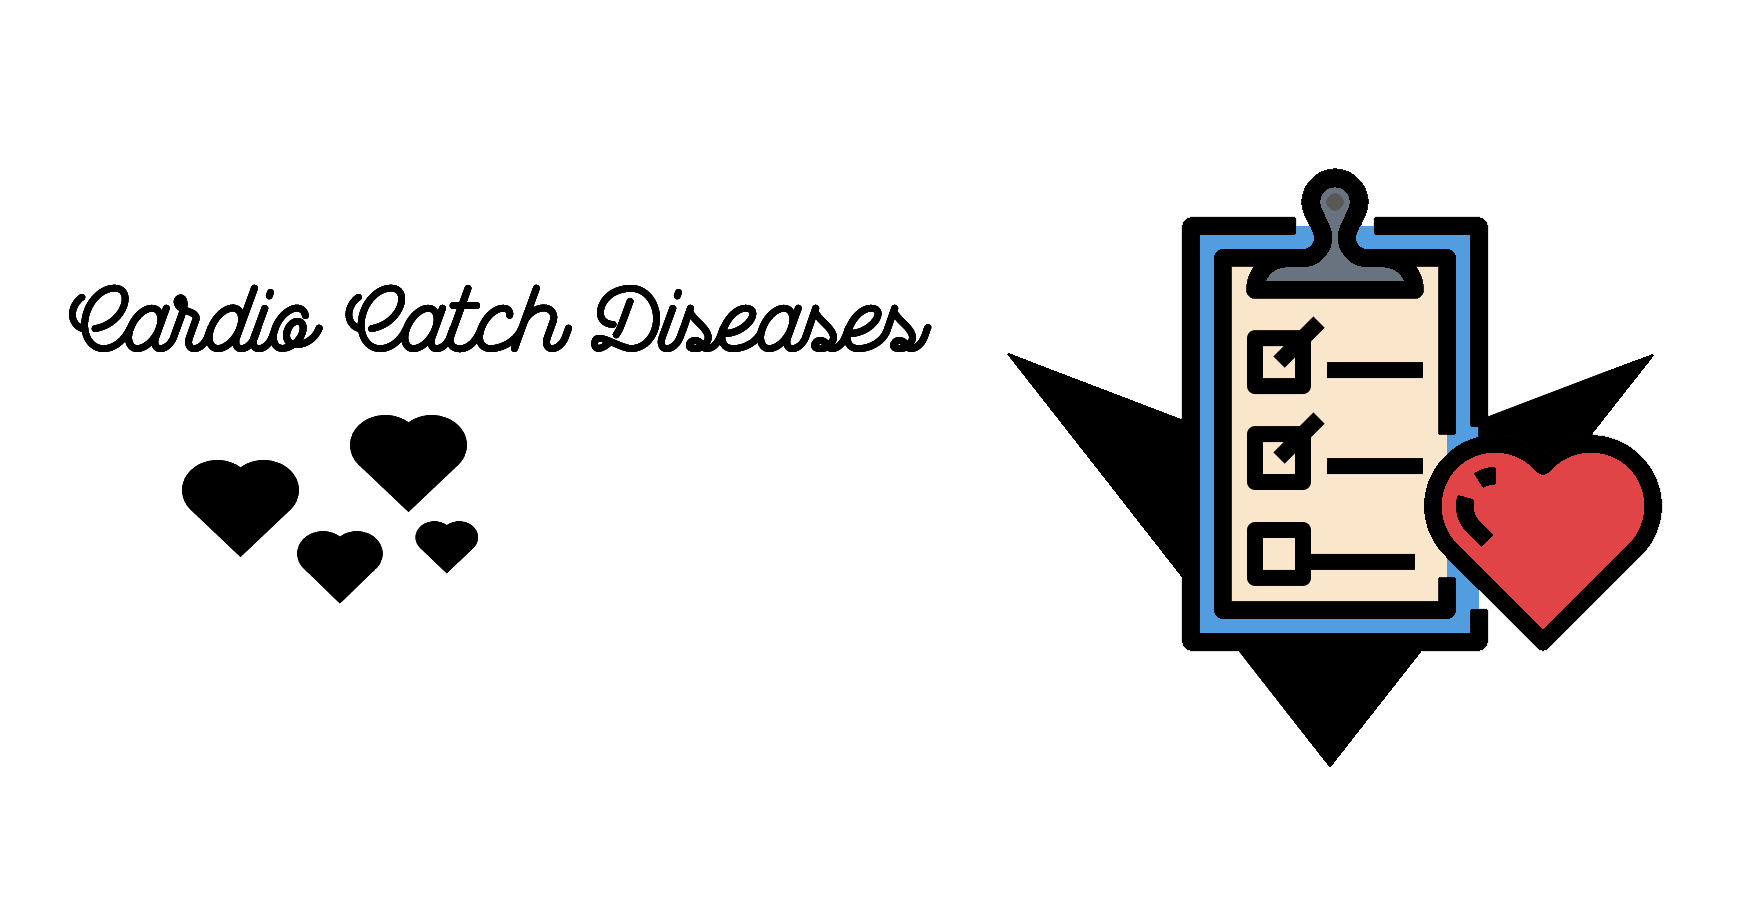

In [3]:
Image("../img/cardio2.png")

<p style="text-align:center"><i>Cadio Catch Diseases is a company specializing in early-stage heart disease detection. Its business model is of the service type, that is, the company offers the early diagnosis of a cardiovascular disease for a certain price.</i></p>

**Bussiness Context**<br>

Currently, the diagnosis of a cardiovascular disease is done manually by a team of specialists. The current accuracy of the diagnosis varies between 55% and 65%, due to the complexity of the diagnosis and also to the fatigue of the team that takes turns to minimize the risks. The cost of each diagnosis, including the equipment and the analysts' payroll, is around R$ 1,000.00.

1. *With a Model, get a better precison on cardiovascular diagnosis.*
2. *What is the precision and accuracy of this new tool?*
3. *How mutch profit the Cardio Catch Diseases will earn with this new tool?* 
4. *What is the confidence interval of this new tool?*

**What is a Cardiovascular Diseases ?**

Cardiovascular Diseases (CVD's) are a group of disorders of the heart and blood vessels.

Heart attacks and strokes are usually acute events and are mainly caused by a blockage that prevents blood from flowing to the heart or brain. The most common reason for this is a build-up of fatty deposits on the inner walls of the blood vessels that supply the heart or brain.

The most important behavioural risk factors of heart disease and stroke are unhealthy diet, physical inactivity, tobacco use and harmful use of alcohol. The effects of behavioural risk factors may show up in individuals as raised blood pressure, raised blood glucose, raised blood lipids, and overweight and obesity. These “intermediate risks factors” can be measured in primary care facilities and indicate an increased risk of heart attack, stroke, heart failure and other complications.

In addition, drug treatment of hypertension, diabetes and high blood lipids are necessary to reduce cardiovascular risk and prevent heart attacks and strokes among people with these conditions.

More Detail at: <a href='https://github.com/xGabrielR/Cardio-Catch-Diseases'>Project Documentation</a>

<font color="red">**Second Cycle**</font>

1. Full Dataset Train Test. (-)
2. Drop Features Train Test. (-)
3. Isolation Forest Test for Outliers. (-)
4. Dataset Balance.
    - Smoteen.
    - Smotetomeklinks.

# 1.0. Model Deployment

## 1.1. Cardio Catch Class

In [21]:
import math
import pickle
import logging
import numpy as np
import pandas as pd

class CardioCatch(object):
    
    def __init__(self):
        self.bmi_scaler = pickle.load(open("bmi_scaler.pkl", "rb"))
        self.age_scaler = pickle.load(open('age_scaler.pkl', 'rb'))
        self.height_scaler = pickle.load(open('height_scaler.pkl', 'rb'))
        self.systolic_scaler = pickle.load(open('systolic_scaler.pkl', 'rb'))
        self.diastolic_scaler = pickle.load(open('diastolic_scaler.pkl', 'rb'))
        self.pulse_pressure_scaler = pickle.load(open("pulse_pressure_scaler.pkl", "rb"))
    
    def data_cleaning(self, df, logger):
        for k in df.columns.tolist():
            try:
                if k == 'weight':
                    df[k] = df[k].astype('float64')
                else:
                    df[k] = df[k].astype('int64')
            except:
                logger.error('[ERROR] Cannot Dataset Preparation Data Types.')
                print('\n[ERRO] Cannot Dataset Preparation Data Types.\n')
       
        df.columns = [p.replace(' ', '_').lower() for p in df.columns.tolist()]
        df.columns = [p.replace('ap_hi', 'systolic').replace('ap_lo', 'diastolic') for p in df.columns]
        df.age     = [math.floor(p/365) for p in df.age.tolist()]
        df.height  = df.height/100
    
        return df
    
    def feature_engineering(self, df, logger):
        try:
            df['pulse_pressure'] = df['systolic'] - df['diastolic']
            df['bmi'] = (df['weight'] / (df['height']**2))
        except:
            logger.error('[ERROR] Cannot Feature Engineering.')
            print('\n[ERRO] Cannot Feature Engineering.\n')
            
        df = df[['age', 'gender', 'height', 'systolic', 'diastolic', 'cholesterol', 'gluc', 'pulse_pressure', 'bmi']]
       
        return df
    
    def data_preparation(self, df, logger):
        try:
            gluc_frequency = {1: 0.869384, 2: 0.070430, 3: 0.060186}
            cholesterol_frequency = {1: 0.762814, 2: 0.132608, 3: 0.104578}

            df.gluc = df.gluc.map(gluc_frequency)
            df.cholesterol = df.cholesterol.map(cholesterol_frequency)
        except:
            logger.error('[ERROR] Cannot Apply Frequency Encoding.')
            print('\n[ERRO] Cannot Apply Frequency Encoding.\n')
        
        try:
            df['bmi'] = self.bmi_scaler.transform(df[['bmi']].values)
            df['age'] = self.age_scaler.transform(df[['age']].values)
            df['height'] = self.height_scaler.transform(df[['height']].values)
            df['systolic'] = self.systolic_scaler.transform(df[['systolic']].values)
            df['diastolic'] = self.diastolic_scaler.transform(df[['diastolic']].values)
            df['pulse_pressure'] = self.pulse_pressure_scaler.transform(df[['pulse_pressure']].values)
        except:
            logger.error('[ERROR] Cannot Apply Scalers.')
            print('\n[ERRO] Cannot Apply Scalers.\n')
        
        return df
    
    def get_prediction(self, model, prepared_dataset, original_dataset):
        yhat = model.predict_proba(prepared_dataset)
        original_dataset['cardio_proba'] = np.round(yhat[:, 1], 3)
        
        return original_dataset.to_json(orient="records")

## 1.2. Flask API

In [31]:
import pickle
import logging
import pandas as pd
from cardiocatch import CardioCatch
from flask import Flask, Response, request

app = Flask(__name__)

if not os.path.exists('Logs'):
    os.makedirs('Logs')

logging.basicConfig(filename='Logs/CardioCatchLogs.txt',
                    level   = logging.INFO,
                    format  = '%(asctime)s - %(levelname)s - %(name)s - %(message)s',
                    datefmt = '%Y-%m-%d %H:%M:%S')

logger = logging.getLogger('APICardioCatch')

model = pickle.load(open("calibrated_ada.pkl", "rb"))

@app.route('/predict', methods=['POST'])
def cardio_predict():
    test_json = request.get_json()
    
    if test_json:
        if isinstance(test_json, dict):
            data = pd.DataFrame(test_json, index=[0])
            
        else:
            data = pd.DataFrame(test_json, columns=test_json[0].keys())
            
        pipe = CardioCatch()
        
        df1 = pipe.data_cleaning(data, logger)
    
        df1 = pipe.feature_engineering(df1, logger)

        df1 = pipe.data_preparation(df1, logger)

        df2 = pipe.get_prediction(model, df1, data)
        
        return df2
        
    else:
        return Response("{}", status=200, mimetype='application/json')

if __name__ == "__main__":
    port = os.environ.get( 'PORT', 5000 )
    app.run( host='0.0.0.0', port=port )
    #app.run('0.0.0.0')

## 1.3. API Tester

In [40]:
import json
import requests
import pandas as pd

df_raw = pd.read_csv('../data/cardio_train.csv', sep=';')
df_raw = df_raw.drop('cardio', axis=1)
df_raw = df_raw.sample(10)
df_raw = json.dumps(df_raw.to_dict(orient="records"))

#url = 'http://0.0.0.0:5000/predict'
url = 'https://cardio-cath-d-app.herokuapp.com/predict'
hdr = {"Content-type": "application/json"}

r = requests.post(url, headers=hdr, data=df_raw)

print(f"Status Code: {r.status_code}")

Status Code: 200


In [41]:
pd.DataFrame(r.json(), columns=r.json()[0].keys()).head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio_proba
0,34819,21783,1,164,72.0,150,90,3,1,0,0,1,1.000
1,32147,22530,1,160,60.0,150,90,3,1,0,0,1,1.000
2,1098,18946,1,152,124.0,120,80,2,2,0,0,1,0.872
